In [1]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, ParameterGrid, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## Defining the s3 bucket
s3 = boto3.resource('s3')
bucket_name = 'data-454'
bucket = s3.Bucket(bucket_name)

## Defining the file to be read from s3 bucket
file_key_train = 'Project_3/orders_train.txt'
file_key_test = 'Project_3/orders_class.txt'

bucket_object_train = bucket.Object(file_key_train)
file_object_train = bucket_object_train.get()
file_content_stream_train = file_object_train.get('Body')

bucket_object_test = bucket.Object(file_key_test)
file_object_test = bucket_object_test.get()
file_content_stream_test = file_object_test.get('Body')

## Reading train file
train = pd.read_csv(file_content_stream_train, sep = ';', na_values = '?')

## Putting dates in the right format
train['orderDate'] = pd.to_datetime(train['orderDate'], format = '%Y-%m-%d') 
train['deliveryDate'] = pd.to_datetime(train['deliveryDate'], format = '%Y-%m-%d')

## Computing days to delivery
train['days_to_delivery'] = (train['deliveryDate'] - train['orderDate']).dt.days
train.head()

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,dateOfBirth,state,creationDate,returnShipment,days_to_delivery
0,1,2012-04-01,2012-04-03,186,m,denim,25,69.90,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,0,2.0
1,2,2012-04-01,2012-04-03,71,9+,ocher,21,69.95,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,1,2.0
2,3,2012-04-01,2012-04-03,71,9+,curry,21,69.95,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,1,2.0
3,4,2012-04-02,NaT,22,m,green,14,39.90,808,Mrs,1959-11-09,Saxony,2012-01-04,0,NaN
4,5,2012-04-02,1990-12-31,151,39,black,53,29.90,825,Mrs,1964-07-11,Rhineland-Palatinate,2011-02-16,0,-7763.0


In [2]:
## Reading test file
test = pd.read_csv(file_content_stream_test, sep = ';', na_values = '?')
test

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,dateOfBirth,state,creationDate
0,1,2013-04-01,2013-04-03,2347,43,magenta,1,89.9,12489,Mrs,1963-04-26,Hesse,2012-04-23
1,2,2013-04-01,2013-04-03,2741,43,grey,1,99.9,12489,Mrs,1963-04-26,Hesse,2012-04-23
2,3,2013-04-01,2013-04-03,2514,9,ecru,19,79.9,12489,Mrs,1963-04-26,Hesse,2012-04-23
3,4,2013-04-01,2013-05-06,2347,42,brown,1,89.9,12489,Mrs,1963-04-26,Hesse,2012-04-23
4,5,2013-04-01,NaN,2690,43,grey,1,119.9,12489,Mrs,1963-04-26,Hesse,2012-04-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50073,50074,2013-04-29,2013-05-03,2342,M,terracotta,5,69.9,91920,Mrs,1962-03-08,Bavaria,2013-04-29
50074,50075,2013-04-29,2013-05-03,2505,M,terracotta,5,64.9,91920,Mrs,1962-03-08,Bavaria,2013-04-29
50075,50076,2013-04-28,2013-05-02,2470,XL,white,5,79.9,85095,Mrs,1950-02-14,Berlin,2013-03-24
50076,50077,2013-04-28,NaN,2452,L,white,5,59.9,91922,Mrs,1969-11-27,Brandenburg,2013-04-28


## Initial Exploration

### Return by ItemID

In [17]:
## Creating table of itemID by return
item_return = pd.DataFrame(pd.crosstab(train['itemID'], train['returnShipment']))
item_return.columns = ['No_Return', 'Return']

## Computing row totals
item_return['Row_Tot'] = item_return['No_Return'] + item_return['Return']

## Computing row-wise percentages
item_return['No_Return_pct'] = item_return['No_Return'] / item_return['Row_Tot']
item_return['Return_pct'] = item_return['Return'] / item_return['Row_Tot']

## Sorting based on Return percentage
item_return = item_return.sort_values(by = 'Return_pct', ascending = False)
item_return['itemID'] = item_return.index
item_return = item_return.reset_index(drop = True)

## Selecting more than 20 orders
item_to_select = item_return[(item_return['Row_Tot'] >= 100) & (item_return['Return_pct'] > 0.6)].reset_index(drop = True)['itemID']
item_to_select

0        60
1        29
2      2456
3       443
4      1144
       ... 
266    1887
267     339
268      42
269    2482
270    1713
Name: itemID, Length: 271, dtype: int64

### Return by Size

In [4]:
## Creating table of size by return 
size_return = pd.DataFrame(pd.crosstab(train['size'], train['returnShipment']))
size_return.columns = ['No_Return', 'Return']

## Computing row totals
size_return['Row_Tot'] = size_return['No_Return'] + size_return['Return']

## Computing row-wise percentages
size_return['No_Return_pct'] = size_return['No_Return'] / size_return['Row_Tot']
size_return['Return_pct'] = size_return['Return'] / size_return['Row_Tot']

## Sorting based on Return percentage
size_return = size_return.sort_values(by = 'Return_pct', ascending = False)
size_return['size'] = size_return.index
size_return = size_return.reset_index(drop = True)

## Selecting more than 20 orders
size_return[(size_return['Row_Tot'] >= 20) & (size_return['Return_pct'] > 0.5)]

,No_Return,Return,Row_Tot,No_Return_pct,Return_pct,size
6,11,20,31,0.354839,0.645161,96
9,177,248,425,0.416471,0.583529,23
11,286,388,674,0.424332,0.575668,50
12,17,23,40,0.425000,0.575000,44+
13,1601,2150,3751,0.426820,0.573180,48
14,900,1192,2092,0.430210,0.569790,8
15,302,396,698,0.432665,0.567335,40+
16,457,598,1055,0.433175,0.566825,10
18,972,1238,2210,0.439819,0.560181,6
19,762,970,1732,0.439954,0.560046,7


### Returns by Manufacturer

In [154]:
## Creating a table of return by manufacter
manufacturer_return = pd.DataFrame(pd.crosstab(train['manufacturerID'], train['returnShipment']))
manufacturer_return.columns = ['No_Return', 'Return']

## Computing the row total
manufacturer_return['Row_Tot'] = manufacturer_return['No_Return'] + manufacturer_return['Return']

## Computing row-wise percentages
manufacturer_return['No_Return_pct'] = manufacturer_return['No_Return'] / manufacturer_return['Row_Tot']
manufacturer_return['Return_pct'] = manufacturer_return['Return'] / manufacturer_return['Row_Tot']

## Sorting based on Return percentage
manufacturer_return = manufacturer_return.sort_values(by = 'Return_pct', ascending = False)
manufacturer_return['manufacturerID'] = manufacturer_return.index
manufacturer_return = manufacturer_return.reset_index(drop = True)

## Selecting more than 20 orders
manufacturer_return[(manufacturer_return['Row_Tot'] >= 1000) & (manufacturer_return['Return_pct'] > 0.5)]

,No_Return,Return,Row_Tot,No_Return_pct,Return_pct,manufacturerID
9,2926,5953,8879,0.329542,0.670458,113
16,1892,3218,5110,0.370254,0.629746,25
17,449,757,1206,0.372305,0.627695,16
19,1753,2890,4643,0.377558,0.622442,45
22,1133,1849,2982,0.379946,0.620054,26
24,934,1469,2403,0.388681,0.611319,53
25,865,1320,2185,0.395881,0.604119,56
28,5988,8861,14849,0.403259,0.596741,20
29,885,1285,2170,0.407834,0.592166,44
30,503,711,1214,0.414333,0.585667,64


In [78]:
x = train[(train['manufacturerID'] == 113)]
a = x['itemID'].value_counts().index.values
a

array([1760, 2328, 2337, 1471, 2363, 2324, 2280, 1444, 1440, 1636, 2456,
       1642, 1884, 1810, 1572, 2688, 2455, 1508, 2355, 2412, 2361, 1903,
       2738, 1896, 2327, 2255, 2042, 2880, 2556])

In [79]:
item_to_select[np.isin(item_to_select, a)]

2      2456
7      1471
16     1636
23     2355
28     2363
35     1642
67     2337
75     2455
99     1760
101    1440
127    2361
215    1903
221    2412
230    1572
231    2280
245    1444
248    1508
253    2688
Name: itemID, dtype: int64

In [149]:
y = train[(train['manufacturerID'] == 113) & (train['itemID'] == 2688)]
y['returnShipment'].value_counts() / y.shape[0]

1    0.609756
0    0.390244
Name: returnShipment, dtype: float64

In [150]:
y['salutation'].value_counts()

Mrs       235
Mr          9
Family      2
Name: salutation, dtype: int64

In [151]:
y.shape

(246, 15)

In [153]:
test[(test['manufacturerID'] == 113) & (test['itemID'] == 2688)].shape

(103, 13)

In [132]:
test.shape

(50078, 13)

### Returns by State

In [7]:
## Creating a table of return by manufacter
state_return = pd.DataFrame(pd.crosstab(train['state'], train['returnShipment']))
state_return.columns = ['No_Return', 'Return']

## Computing the row total
state_return['Row_Tot'] = state_return['No_Return'] + state_return['Return']

## Computing row-wise percentages
state_return['No_Return_pct'] = state_return['No_Return'] / state_return['Row_Tot']
state_return['Return_pct'] = state_return['Return'] / state_return['Row_Tot']

## Sorting based on Return percentage
state_return = state_return.sort_values(by = 'Return_pct', ascending = False)
state_return['state'] = state_return.index
state_return = state_return.reset_index(drop = True)
state_return

,No_Return,Return,Row_Tot,No_Return_pct,Return_pct,state
0,2749,2838,5587,0.492035,0.507965,Saxony-Anhalt
1,7317,7552,14869,0.492098,0.507902,Saxony
2,3559,3608,7167,0.496582,0.503418,Mecklenburg-Western Pomerania
3,3568,3608,7176,0.497213,0.502787,Thuringia
4,5372,5412,10784,0.498145,0.501855,Brandenburg
5,12357,11858,24215,0.510304,0.489696,Rhineland-Palatinate
6,12178,11489,23667,0.514556,0.485444,Schleswig-Holstein
7,35558,33487,69045,0.514997,0.485003,Lower Saxony
8,35384,33265,68649,0.515434,0.484566,Bavaria
9,19018,17807,36825,0.516443,0.483557,Hesse


### Computing days to delivery

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


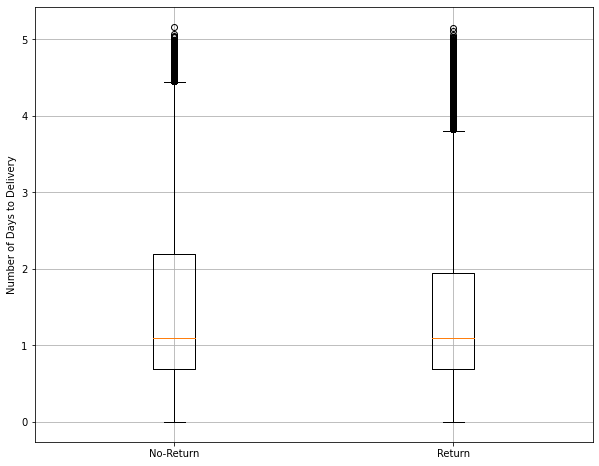

In [25]:
## Creating a new figure
plt.figure(figsize = (10, 8))

## Subsetting the data
return0 = train[(train['returnShipment'] == 0) & (train['days_to_delivery'] >= 0)]
return1 = train[(train['returnShipment'] == 1) & (train['days_to_delivery'] >= 0)]

## Creating side-by-side box plots
plt.boxplot([np.log(return0['days_to_delivery']), np.log(return1['days_to_delivery'])], labels = ['No-Return', 'Return'])
plt.ylabel('Number of Days to Delivery')
plt.grid()

## saving the plot
# plt.savefig('side_by_side_boxplot.pdf')

plt.show()

In [22]:
return1

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,dateOfBirth,state,creationDate,returnShipment,days_to_delivery
1,2,2012-04-01,2012-04-03,71,9+,ocher,21,69.95,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,1,2.0
2,3,2012-04-01,2012-04-03,71,9+,curry,21,69.95,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,1,2.0
3,4,2012-04-02,NaT,22,m,green,14,39.90,808,Mrs,1959-11-09,Saxony,2012-01-04,0,NaN
4,5,2012-04-02,1990-12-31,151,39,black,53,29.90,825,Mrs,1964-07-11,Rhineland-Palatinate,2011-02-16,0,-7763.0
5,6,2012-04-02,1990-12-31,598,xxl,brown,87,89.90,825,Mrs,1964-07-11,Rhineland-Palatinate,2011-02-16,0,-7763.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481086,481087,2013-03-31,2013-04-09,2561,39,blue,1,139.90,7032,Mr,1962-12-17,Lower Saxony,2011-03-12,1,9.0
481087,481088,2013-03-31,2013-04-09,2561,39+,blue,1,139.90,7032,Mr,1962-12-17,Lower Saxony,2011-03-12,1,9.0
481089,481090,2013-03-31,1990-12-31,2458,XXL,black,5,99.90,86611,Mr,1973-05-16,Berlin,2013-03-31,0,-8126.0
481090,481091,2013-03-31,1990-12-31,2659,XXL,black,49,99.90,86611,Mr,1973-05-16,Berlin,2013-03-31,0,-8126.0


In [18]:
train[train['days_to_delivery'] < 0]['deliveryDate']

4        1990-12-31
5        1990-12-31
6        1990-12-31
215      1990-12-31
272      1990-12-31
            ...    
480836   1990-12-31
480943   1990-12-31
481089   1990-12-31
481090   1990-12-31
481091   1990-12-31
Name: deliveryDate, Length: 4660, dtype: datetime64[ns]

In [20]:
4660 / train.shape[0]

0.00968629700764095